In [2]:
import math
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import logging
LOG_FORMAT = "%(asctime)s [%(levelname)s] %(message)s"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT, datefmt=DATE_FORMAT)

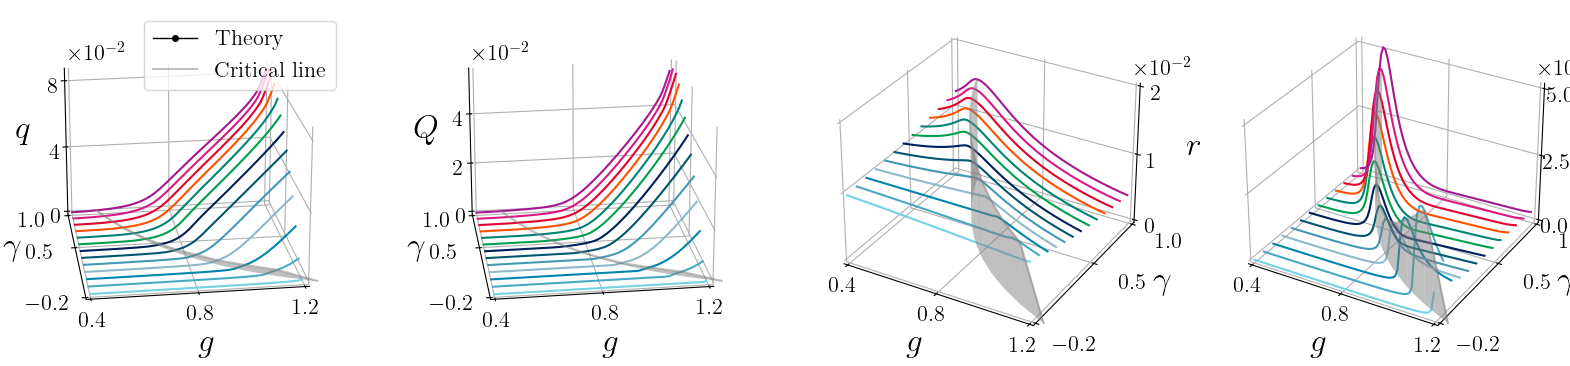

In [10]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
prefixPath = "../../Data/results/2/a1/"
beta = 10000.0
eta = 0.0
gammaLists = [-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colorLists = ["#74d2e7", "#48a9c5", "#0085ad", "#8db9ca", "#4298b5", "#005670", "#00205b", "#009f4d", "#008374", "#fe5000", "#e4002b", "#da1884", "#a51890"]
nonLinearity = 'tanh'
indexs = [0, 1, 4, 5]
titles = ["q", "Q", "r", "R"]
lineHeight = [0.0, 0.0, 0.014, 0.0]
zTickLists = [[0.00, 0.04, 0.08],
              [0.00, 0.02, 0.04],
              [0.00, 0.01, 0.02],
              [0.00, 0.00025, 0.0005]]
fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={
    "projection": '3d'
})
for i in range(len(indexs)):
    if i < 2:
        ax[i].view_init(elev=21, azim=-98)
    # ax[i].grid(False)
    ax[i].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[i].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[i].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[i].tick_params(direction="out", which='both')

    criticlePointHeight = []
    maxValue = 0
    for j, gamma in enumerate(gammaLists):
        record = torch.load(prefixPath + f"/gCurve-beta{beta}-gamma{gamma}-gi0.4-gf1.2-eta{eta}-{nonLinearity}.pt")
        gList = torch.tensor(record["gList"])[:record["currentIndex"]+1]
        gammaAxese = torch.ones_like(gList) * gamma


        minusBetaFList = record["minusBetaF"]
        energyList = record["energy"]
        L2NormList = record["L2Norm"]
        QList = record["Qs"]
        entropyList = minusBetaFList + beta * energyList
        sigma = torch.sqrt(1 + beta * (gList**2) * (QList[0] - QList[1]))

        # ax[i]scatter(gList, gammaAxese, QList[0], s=1)
        ax[i].plot3D(gList, gammaAxese, QList[indexs[i]], linewidth=1.5, marker="", markersize=1, color=colorLists[j])

        criticlePointHeight.append(QList[indexs[i]][int(
            (1 / (1 + gamma) - 0.4) / 0.01
        )].item() if gamma >= -0.1 else 0.0)
        maxValue = max(maxValue, torch.max(QList[indexs[i]]).item())

    criticlePoint = 1 / (1 + torch.tensor(gammaLists))
    # z = torch.linspace(0, torch.max(torch.tensor(criticlePointMaxHeight * 1.1)), 100)
    # y = torch.tensor(gammaLists)
    # Y, Z = torch.meshgrid(y, z)
    # X = 1 / (1 + Y)
    # ax[i].plot_surface(X, Y, Z, alpha=0.5, color="red")
    ax[i].plot(criticlePoint, gammaLists, criticlePointHeight, alpha=0.5, c='grey', label="Critical line")
    for j in range(len(criticlePoint)-1):
        verts = [(criticlePoint[j],gammaLists[j],criticlePointHeight[j]), (criticlePoint[j+1],gammaLists[j+1],criticlePointHeight[j+1])] + \
                [(criticlePoint[j+1],gammaLists[j+1],0), (criticlePoint[j],gammaLists[j],0)]
        
        ax[i].add_collection3d(Poly3DCollection([verts],
                                                alpha=0.5,
                                                linewidths=0,
                                                color="grey"))
    ax[i].set_xlabel("$g$", fontsize=24, weight="bold")
    # ax[i].set_ylabel("$\\gamma$", fontsize=20, weight="bold")
    ax[i].text(0.1 if i < 2 else 1.5, 0.4, ax[i].get_zlim()[0], '$\\gamma$', fontsize=24, weight="bold")
    ax[i].set_zlabel("${}$".format(titles[i]), fontsize=24)
    ax[i].set_xticks([0.4, 0.8, 1.2])
    ax[i].set_yticks([-0.2, 0.5, 1.0])
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set(label_position="lower")
    ax[i].set_zticks(zTickLists[i])
    ax[i].tick_params(labelsize=16)
    ax[i].tick_params(axis='x', pad=-2)
    for ytick in ax[i].get_yticklabels():
        ax[i].text(ax[i].get_xlim()[0 if i < 2 else 1] + (-0.12 if i < 2 else +0.12), ytick._x - 0.1, ax[i].get_zlim()[0],
            '$\\mathdefault{%.1f}$' % ytick._x, fontsize=16, ha="center", va="center")
    ax[i].tick_params(axis='z', pad=-1)
    ax[i].set_xlim((0.4, 1.2))
    ax[i].set_ylim((-0.2, 1.0))
    ax[i].ticklabel_format(style='sci', scilimits=(-1,2), axis='z')
    ax[i].zaxis.get_offset_text().set_visible(False)
    ax[i].zaxis.set_visible(False)
    exponent = int('{:.2e}'.format(maxValue).split('e')[1])
    ax[i].text(ax[i].get_xlim()[0 if i < 2 else 1], ax[i].get_ylim()[1], ax[i].get_zlim()[1]*1.1,
            '$\\times\\mathdefault{10^{%d}}$' % exponent, fontsize=16)
    if i == 0:
        ax[i].plot3D([], [], [], linewidth=1, marker="o", markersize=4, label="Theory", color="black")
        handles, labels = ax[i].get_legend_handles_labels()
        order = [1, 0]
        ax[i].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=16, loc="upper right")

# plt.savefig("../../Data/figures/fig3-orderParameters.pdf", bbox_inches="tight", pad_inches=0.5)
plt.show()
plt.close()

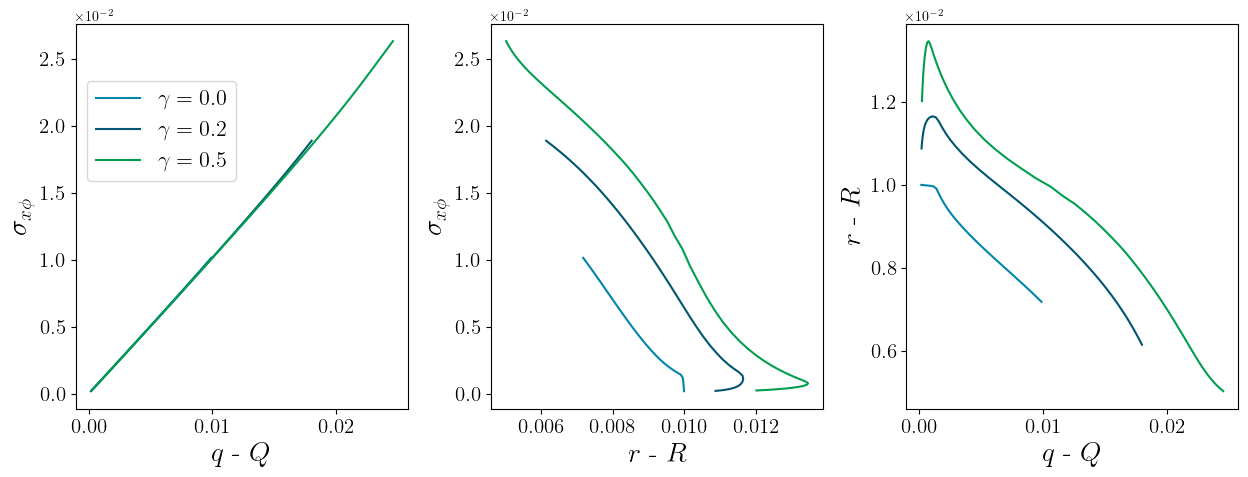

In [22]:
prefixPath = "../../Data/results/2/a1/"
beta = 10000.0
eta = 0.0
# gammaLists = [-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# colorLists = ["#74d2e7", "#48a9c5", "#0085ad", "#8db9ca", "#4298b5", "#005670", "#00205b", "#009f4d", "#008374", "#fe5000", "#e4002b", "#da1884", "#a51890"]
gammaLists = [0.0, 0.2, 0.5]
colorLists = ["#0085ad", "#005670", "#009f4d"]
nonLinearity = 'tanh'
indexs = [0, 1, 4, 5]
titles = ["q", "Q", "r", "R"]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={
    "wspace": 0.25
})
miny = 10
maxy = -10
for j, gamma in enumerate(gammaLists):
    record = torch.load(prefixPath + f"/gCurve-beta{beta}-gamma{gamma}-gi0.4-gf1.2-eta{eta}-{nonLinearity}.pt")
    criticle = int((1 / (1 + gamma) - 0.4) // 0.02)
    gList = torch.tensor(record["gList"])[:record["currentIndex"]+1][criticle:]

    minusBetaFList = record["minusBetaF"][criticle:]
    energyList = record["energy"][criticle:]
    L2NormList = record["L2Norm"][criticle:]
    QList = record["Qs"][:, criticle:]
    entropyList = minusBetaFList + beta * energyList

    axs[2].plot(QList[0] - QList[1], QList[4] - QList[5], marker="", color=colorLists[j], label=f"$\\gamma={gamma}$") # q - Q vs r - R

    sigmapx = - (QList[5] - QList[4]) * (1 + beta * gList**2 * (QList[0] - QList[1]) * (1 + gamma)) / (math.sqrt(beta))

    axs[0].plot(QList[0] - QList[1], sigmapx, marker="", color=colorLists[j], label=f"$\\gamma={gamma}$") # q - Q vs sigma_x_p
    axs[1].plot(QList[4] - QList[5], sigmapx, marker="", color=colorLists[j], label=f"$\\gamma={gamma}$") # r - R vs sigma_x_p

    # miny = min(miny, torch.min(sigmapx).item())
    # maxy = max(maxy, torch.max(sigmapx).item())

[axs[t].ticklabel_format(style='sci', scilimits=(-1,2), axis='y') for t in range(3)]
[axs[t].tick_params(labelsize=15) for t in range(3)]

axs[0].set_xlabel("$q$ - $Q$", fontsize=20, weight="bold")
axs[0].set_ylabel("$\\sigma_{x \\phi}$", fontsize=20, weight="bold")
axs[1].set_xlabel("$r$ - $R$", fontsize=20, weight="bold")
axs[1].set_ylabel("$\\sigma_{x \\phi}$", fontsize=20, weight="bold")
axs[2].set_xlabel("$q$ - $Q$", fontsize=20, weight="bold")
axs[2].set_ylabel("$r$ - $R$", fontsize=20, weight="bold")


axs[0].legend(fontsize=16, bbox_to_anchor=(0, 0.88), loc="upper left")

# plt.savefig("./fig5-xi-chi-vs-sigma-px.pdf", bbox_inches="tight")
plt.show()
plt.close()